In [1]:
import numpy as np
from scipy import optimize, stats
import math
import random
import matplotlib.pyplot as plt

def ReLU(x):
    return x*(x>0)

# Calcium Plasticity

In [2]:
def Cal_step(s_pre, s_post, s_inh, v, ca, glu, w):
    #dVp = -1/tauVp*(Vp-V0)*plateua + w*s_pre + bp*(s_post-s_inh)
    #dCa = -1/tauCa*Ca + Gl*(1e-2*(Vp-V0) + 1e-1*ReLU(Vp-V1))
    #dGl = -1/tauGl*Gl + release * s_pre
    #LTD =  1e-2  * np.log(ReLU(Ca-0.4)+1) * ReLU(Gl-0.1)
    #LTD =  1e-2  * np.log(ReLU(Ca)+1) * ReLU(Gl-0.1)*(w-wmin)
    #LTP = 2e-3  * ReLU(Ca-1) * (wmax-w)
    #dw = lr*(LTP-LTD) 
    #Vp += dt*dVp
    #Ca += dt*dCa
    #Gl += dt*dGl
    #w += dt*dw
    
    dv = -1/tau_v*(v-V0)*plateua + w*s_pre + bp*(s_post-s_inh) #EPSP
    dca = -ca/tau_ca + glu*1e-1*ReLU(Vp-V1)
    dglu = -glu/tau_glu + release*s_pre
    dmGlu = -mGlu/tau_mGlu + 0.1*glu
    #dtheta = -(theta-baseline)/tau_theta + 0.2*s_post
    
    ltd = ReLU(mGlu-0.4)*np.log(ca+1)*(w-wmin)
    ltp = ReLU(ca-theta)*(wmax-w)
    dw = lr*(LTP-LTD)
    
    ca += dt * dca
    glu += dt * dglu
    mGlu += dt * dmGlu
    v += dt*dv
    w += dt*dw
    
    #theta += dtheta
    
    return Vp, Ca, Gl, w

In [158]:
def Cal_step(s_pre, s_post, s_inh, v, ca, glu, mglu, w):
    
    dv = -1/tau_v*(v-V0)*plateua + w*s_pre + bp*(s_post-s_inh) #EPSP, backpropagated spike will be shunted by inhibition
    dca = -ca/tau_ca + glu*(1e-2*(v-V0) + 1e-1*ReLU(v-V1))
    dglu = -glu/tau_glu + release*s_pre
    dmglu = -mglu/tau_mglu + 1e-1*glu
    #dtheta = -(theta-baseline)/tau_theta + 0.2*s_post
    
    ltd = ReLU(mglu-0.1)*np.log(ca+1)*(w-wmin)
    ltp = gain*ReLU(ca-1)*(wmax-w)
    dw = lr*(ltp-ltd)
    
    ca += dt * dca
    glu += dt * dglu
    mglu += dt * dmglu
    v += dt*dv
    w += dt*dw
    
    #theta += dtheta
    
    return v, ca, glu, mglu, w

In [159]:
def Cal_simulation(S_pre, S_post, S_inh, w_ini = 1):
    Vp, Ca, Glu, MGlu, W = [V0], [0], [0], [0], [w_ini]
    for t in range(len(S_pre)):
        v, ca, glu, mglu, w = Cal_step(S_pre[t], S_post[t], S_inh[t], Vp[-1], Ca[-1], Glu[-1], MGlu[-1], W[-1])
        Vp.append(v)
        Ca.append(ca)
        Glu.append(glu)
        MGlu.append(mglu)
        W.append(w)
    
    return Vp, Ca, Glu, MGlu, W
   

In [175]:
V0, V1 = -70, -60
wmin, wmax = 0, 2
release, gain, bp =1, 0.2, 25 #Quanta_content
dt, tau_v, tau_ca, tau_glu, tau_mglu = 1, 10, 40, 20, 10
plateua, lr = 1, 1e-2

pre_spikes = [10, 100, 240, 350]
post_spikes = [30, 105, 230, 345]

S_pre = np.zeros([500])
S_post = np.zeros([500])
S_inh = np.zeros([500])
S_pre[pre_spikes] = 1
S_post[post_spikes] = 1

VP, CA, GL, MGLU, W = Cal_simulation(S_pre, S_post, S_inh)

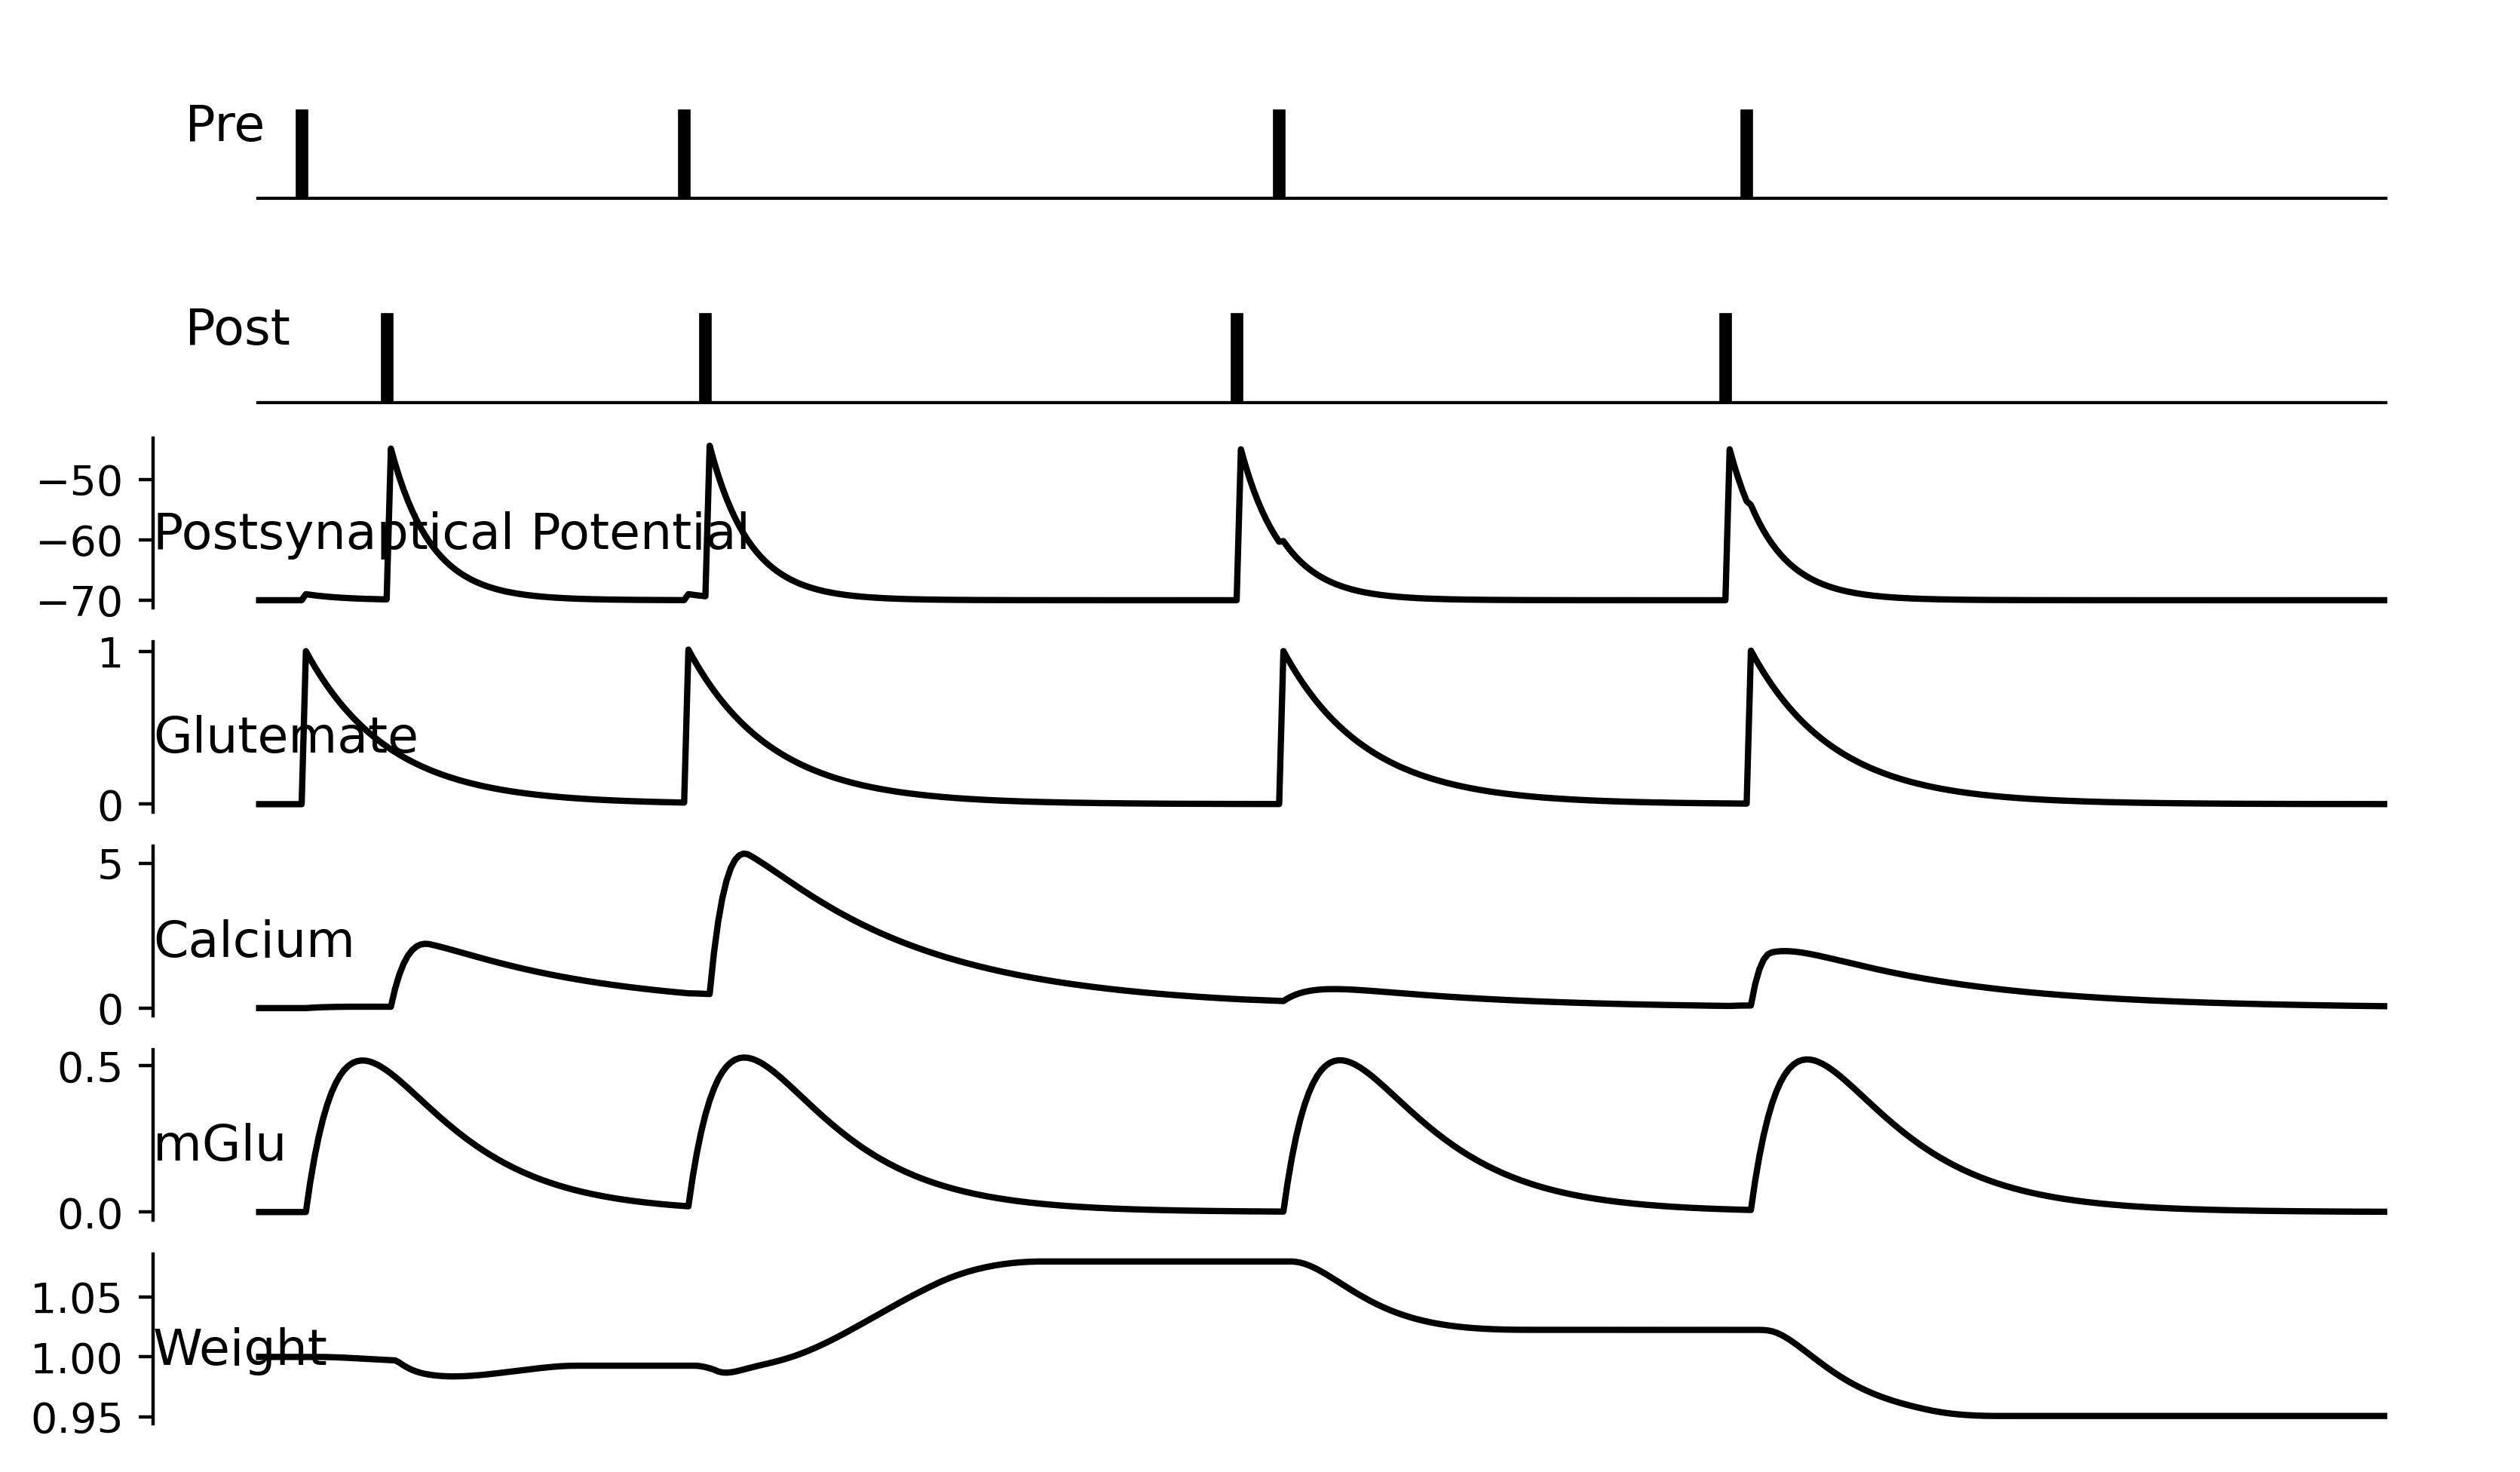

In [176]:
fig, ax = plt.subplots(nrows=7,  sharex=True)
fig.set_figwidth(10)
fig.set_figheight(6)
fig.set_dpi(400)
x = np.arange(0,501)

ax[0].plot(x, np.zeros([501]), 'black')
for t in pre_spikes:
    ax[0].axvline(x=t, ymin=0, ymax=.5, color='black', lw=3)
ax[0].set(ylim=(0, 1))
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].set_title('  Pre', loc='left', y = 0.2)

ax[1].plot(x, np.zeros([501]), 'black')
for t in post_spikes:
    ax[1].axvline(x=t, ymin=0, ymax=.5, color='black', lw=3)
ax[1].set(ylim=(0, 1))
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].set_title('  Post', loc='left', y = 0.2)

ax[2].plot(x, VP, 'black')
#ax[2].set(ylim=(0, 1))
#ax[2].set_yticks([0.0,1.0])
ax[2].spines['left'].set_visible(True)
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_title('Postsynaptical Potential', loc='left', y = 0.2)

ax[3].plot(x, GL, 'black')
#ax[3].set(ylim=(0, 1))
#ax[3].yticks(False)
#ax[3].set_yticks([0.0,1.0])
ax[3].spines['top'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].set_title('Glutemate', loc='left', y = 0.2)

ax[4].plot(x, CA, 'black')
#ax[4].set(ylim=(0, 1))
#ax[4].set_yticks([0.0,1.0])
ax[4].set_xticks([])
ax[4].spines['top'].set_visible(False)
ax[4].spines['bottom'].set_visible(False)
ax[4].spines['right'].set_visible(False)
ax[4].set_title('Calcium', loc='left', y = 0.2)

ax[5].plot(x, MGLU, 'black')
#ax[5].set(ylim=(0, 1))
#ax[5].set_yticks([0.0,1.0])
ax[5].set_xticks([])
ax[5].spines['top'].set_visible(False)
ax[5].spines['bottom'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].set_title('mGlu', loc='left', y = 0.2)

ax[6].plot(x, W, 'black')
#ax[5].set(ylim=(0, 1))
#ax[5].set_yticks([0.0,1.0])
ax[6].set_xticks([])
ax[6].spines['top'].set_visible(False)
ax[6].spines['bottom'].set_visible(False)
ax[6].spines['right'].set_visible(False)
ax[6].set_title('Weight', loc='left', y = 0.2)


plt.show()

In [177]:
pre_timing = np.arange(160, 240)
post_spikes = [200]
Ws = []

for t in pre_timing:
    S_pre = np.zeros([500])
    S_post = np.zeros([500])
    S_inh = np.zeros([500])
    S_pre[t] = 1
    S_post[post_spikes] = 1

    VP, CA, GL, MGLU, W = Cal_simulation(S_pre, S_post, S_inh)
    Ws.append(W[-1])
    

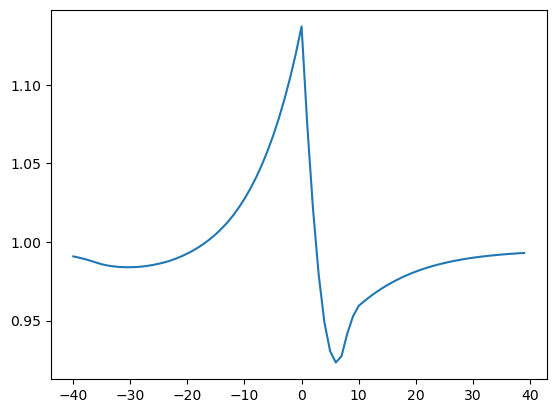

In [178]:
fig = plt.figure()
plt.plot(pre_timing-200, Ws)

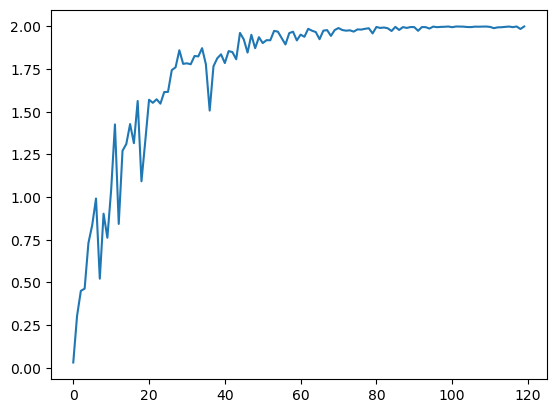

In [96]:
duration = 1000
freq = 120
Ws = np.zeros(freq)

S_pre = np.random.random(duration) < 80/1000
S_pre[-60:] = 0
S_inh = np.zeros([duration])

for hz in range(freq):
    for i in range(10):
        S_post = np.random.random(duration) < (hz+1)/1000
        VP, CA, GL, W = Cal_simulation(S_pre, S_post, S_inh, w_ini = 1.7)
        Ws[hz]+=W[-1]
    Ws[hz]/=10

plt.plot(np.arange(freq), Ws)

# Spiking Simulation

In [ ]:
class Neurons():
    def __init__(self, args):
        self.n_neurons = args['n_neurons']
        self.label = args['label']     #setup group name       
        self.spiking = np.zeros(n_neurons)
           
    def step(self, spiking):
        self.spiking = spiking


class LIFNeurons(Neurons):
    def __init__(self, args):
        super().__init__(args)
        self.n_neurons = args['n_neurons']
        self.label = args['label']     #setup group name       
        self.tau = args['tau']         #time constant
        self.V0 =args['V0']            #rest membrane potential
        self.V_reset = args['V_reset']  #after spike hyperpolarization
        
        self.V = np.full(n_neurons, V0) # membrane potential
        self.integrate = np.zeros(n_neurons)  #integrated dendrite current
        

    
    def step(self, current):
        self.V += (-(self.V-self.V0)/self.tau + self.integrate + current)*dt
        self.spiking = self.V >= self.threshold
        
        self.V[self.spiking]=self.V_reset                  
        self.integrate = 0
                                      
        

In [ ]:
class Synapses():
    def __init__(self, preNeurons:Neurons, postNeurons:Neurons, args):
        #connectome: Matrix of n_pre_neuron * n_post_neuron
        
        self.preNeurons=preNeurons
        self.postNeurons=postNeurons
        self.learn = LearningRule
        
        self.connectome = args['connectome']
        self.wmax= args['wmax'] 
        self.wmin= args['wmin']       
        self.w = np.full_like(self.connectome, 0)
        self.dt = dt
        #self.dendrites = np.zeros_like(self.connectome)        
           
        
    def step(self, ModuCon):
        s_pre  = self.preNeurons.spiking()
        s_pre  = np.tile(s_pre, (self.connectome.shape[0],1))
        if self.learn != None:           
            s_post = self.postNeurons.spiking()
            s_post  = np.tile(s_post, (1, self.connectome.shape[1]))
            self.learn(s_pre, s_post, ModuCon)
        self.integrate(s_pre)

        
    def integrate(self, s_pre):
        self.postNeurons.integrate += (s_pre*self.w)# + self.dendrites)
        
    

In [ ]:
class LearningRule(Synapses):
    def __init__(self, args):
        super().__init__(preNeurons, postNeurons, args)
        self.tau_pre = args['tau_pre_trace']
        self.tau_post = args['tau_post_trace']
        self.tau_elig = args['tau_elig']
        self.connectome = args['connectome']
        self.pre_trace = np.zeros_like(self.connectome)
        self.post_trace= np.zeros_like(self.connectome)
        
    def learn(ss_pre, s_post, ModuCon):
        self.LearningRule(self.pre_trace, self.post_trace, s_pre, s_post)
        self.pre_trace += s_pre - self.pre_trace/self.tau_pre
        self.post_trace += s_post  - self.post_trace/self.tau_post
        
        

In [ ]:
class Network():
    def __init__(self, NeuronsGroups, Connections):

        self.NeuGroups = {}
        self.SynGroups = {}
        self.Modulators = Modulators
        self.ModuCon = {} #Modulator concentration
        
        #initiate neuron groups
        for groupArgs in NeuronsGroups:
            self.NeuGroups[groupArgs['label']] = Neurons(groupArgs)
        
        #initiate synapses
        for connectionArgs in Connections:
            preName = connectionArgs['preNeurons']
            postName = connectionArgs['postNeurons']
            preNeurons=self.NeuGroups[preName]
            postNeurons=self.NeuGroups[postName]
            self.SynGroups[preName+postName] = Synapses(preNeurons, postNeurons, connectionArgs)
            
        for modulator, args in self.Modulators:
            self.ModuCon[modulator] = 0
        
        
        
    def step(self,state):

        for connection in self.SynGroups:
            connection.step(self.ModuCon)
        for label, group in self.NeuGroups:
            group.step(state[label])
        for modulator, MoArgs in self.Modulators:            
            self.ModuCon[modulator] += MoArgs['lamda'] * self.NeuGroups[modulator].spiking.sum()
                - self.ModuCon[modulator]/MoArgs['tau'] * self.dt
            
        

In [1]:
class Enviornment():
    def __init__(self, n_neuron, neurontype, connectome, decay_s, decay_l, lr, V0, Vrest):
        excNeurons = ExcNeurons()
        inhNeurons = InhNeurons()
        
    def step(self,action):
        return reward
    
    def state(self):
        #encode perception and reward into current
        
        return state

In [ ]:
class Simulation():
    def __init__(self, n_neuron, neurontype, connectome, decay_s, decay_l, lr, V0, Vrest):
        self.network = Network()
        self.env = Enviornment()
        self.Reward = []
        
    def step(self,):
        state = self.env.state()
        action = self.network.step(state)
        reward = self.env.step(action)
        self.Reward.append(reward)
    
    def run(self,)
        for t in duration:
            self.step()